In [1]:
import torch
import torch.nn as nn
import torch.functional as F 
import math 
import numpy as np
from transformers import AutoTokenizer

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
input_text = [
    "hello world", "My name is vivek", "I am a billionaire", "I am 29 years old"
]

embeddings = tokenizer(input_text, padding=True)["input_ids"]
embeddings

[[101, 19082, 1362, 102, 0, 0, 0, 0],
 [101, 1422, 1271, 1110, 191, 2109, 1377, 102],
 [101, 146, 1821, 170, 26961, 102, 0, 0],
 [101, 146, 1821, 1853, 1201, 1385, 102, 0]]

## Making a tokenizer myself

In [ ]:
# breaking down the sentences

sentences = [
    "hello world", "My name is vivek", "I am a billionaire", "I am 29 years old"
]
tokenized = [s.lower().split() for s in sentences]
tokenized

[['hello', 'world'],
 ['my', 'name', 'is', 'vivek'],
 ['i', 'am', 'a', 'billionaire'],
 ['i', 'am', '29', 'years', 'old']]

In [ ]:
# building the vocabulary

vocab = {"<PAD>": 0}
max_len = 0
for sentence in tokenized:
    max_len = max(max_len, len(sentence))
    for word in sentence:
        if word not in vocab:
            vocab[word] = len(vocab)

vocab
# max_len

{'<PAD>': 0,
 'hello': 1,
 'world': 2,
 'my': 3,
 'name': 4,
 'is': 5,
 'vivek': 6,
 'i': 7,
 'am': 8,
 'a': 9,
 'billionaire': 10,
 '29': 11,
 'years': 12,
 'old': 13}

In [ ]:
# creating token ids
token_ids = [[vocab[word] for word in sentence] for sentence in tokenized]
token_ids

[[1, 2], [3, 4, 5, 6], [7, 8, 9, 10], [7, 8, 11, 12, 13]]

In [14]:
# padding the sequeces
padded_ids = [s + [0]*(max_len - len(s)) for s in token_ids]

final_ids = torch.tensor(padded_ids)
final_ids

tensor([[ 1,  2,  0,  0,  0],
        [ 3,  4,  5,  6,  0],
        [ 7,  8,  9, 10,  0],
        [ 7,  8, 11, 12, 13]])

## 🚧 Phase 2: Embedding + Positional Encoding

In [ ]:
# 🧠 Step 2.1: Token Embedding
# ✅ TASK
# Use the vocab you built in the last step.

embeddings_layer = torch.nn.Embedding(num_embeddings=len(vocab), embedding_dim=512 )
output_embeddings = embeddings_layer(final_ids)
output_embeddings

# NOTE -  NOW OUR EMBEDDINGS ARE OF SHAPE -- [BATCH , SEQ_LENGTH , EMBEDDING_DIMENSIONS]
# BATCH - NUMBER OF SENTENCES
# SEQ_LENGTH - NUMBER OF WORDS IN A SENTENCE
# EMBEDDING_DIMENSIONS - PRE DEFINED 512
# BECAUSE FOR EACH TOKEN ID (THAT REPRESENTS A SINGLE WORD) - IT GENERATES A VECTOR 

tensor([[[-0.7182, -1.1198,  0.6211,  ...,  0.2948, -1.7614,  2.0537],
         [ 1.0140,  0.6188,  1.0397,  ...,  0.7763, -0.1568, -0.7988],
         [-0.4088,  0.6579,  0.4000,  ...,  0.7276,  0.8227, -1.1133],
         [-0.4088,  0.6579,  0.4000,  ...,  0.7276,  0.8227, -1.1133],
         [-0.4088,  0.6579,  0.4000,  ...,  0.7276,  0.8227, -1.1133]],

        [[-0.6441,  0.4489,  1.1560,  ..., -0.7413,  0.2573, -0.3828],
         [ 0.9844, -0.2105,  1.1086,  ..., -0.7989, -0.7727,  0.3005],
         [ 0.2784, -0.0127,  0.4338,  ...,  1.8069, -0.0522, -0.6200],
         [ 0.9816,  1.1601, -0.4487,  ...,  0.4984,  2.2760,  0.2132],
         [-0.4088,  0.6579,  0.4000,  ...,  0.7276,  0.8227, -1.1133]],

        [[-0.2989, -2.2049, -0.3868,  ..., -1.0740,  0.7554, -0.4955],
         [-0.6054,  0.7929,  0.9495,  ..., -1.5792,  0.5818, -1.3401],
         [ 1.1726, -1.6072, -0.4947,  ..., -1.0268,  0.6969, -0.6144],
         [ 0.2876, -0.0720, -0.2782,  ...,  1.0257, -0.2649, -1.5968],
  

## Add Positional Encoding
Use this formula:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right) \\
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)
$$

---
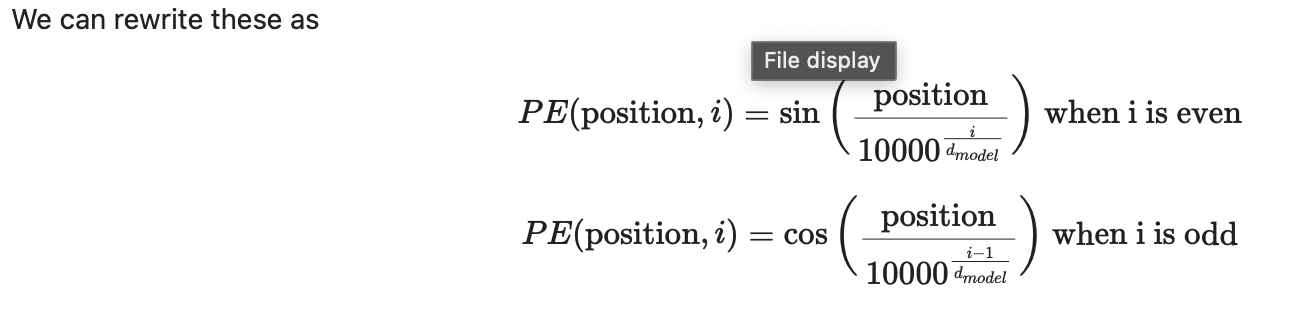

In [20]:
# 🚧 Phase 3: Add Positional Encoding
# import torch
# import math

# def get_positional_encoding(seq_length, d_model):
#     pe = torch.arange(seq_length, d_model)

#     for pos in range(seq_length):
#         for d in range(0,d_model,2): # iterating alternate numbers only
#             angle = pos / torch.exp(10000 / (d/d_model))
#             pe[pos, d] = math.sin(angle) # this covers the even positions 
#             if d+1 < d_model:
#                 pe[pos, d+1] = math.cos(angle)
#     return pe 

import torch
import math

def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)

    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            denom = 10000 ** (i / d_model)
            angle = pos / denom
            pe[pos, i] = math.sin(angle)
            if i + 1 < d_model:
                pe[pos, i + 1] = math.cos(angle)

    return pe


# 🧠 What it does:
# -For each position pos (like token 0, 1, 2...):
# -For each even dimension i, calculate angle = pos / (10000^(i/d))
# Set:
#     - pe[pos, i] = sin(angle)
#     - pe[pos, i+1] = cos(angle) (if i+1 is within range)


In [21]:
pe = get_positional_encoding(4, 8)  # 4 tokens, 8-dimensional embedding
print(pe.shape)                     # torch.Size([4, 8])
print(pe)


torch.Size([4, 8])
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
          9.9980e-01,  2.0000e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9996e-02,
          9.9955e-01,  3.0000e-03,  1.0000e+00]])
